<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/HUPV/notebooks/solutions/cv09_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9. Cvičenie - Rekurentné siete

Na dnešnom cvičení si precvičíme prácu s rekurentnými sieťami. Vytvoríme si mierne umelý príklad, v ktorom skonštruujeme veľké číslo zo sekvencie MNIST čísel a vrátime honotu po aplikácii modula nejakým číslom (ideálne prvočíslo nad 10).

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
import numpy as np
x = np.array(mnist.data.astype('float32')/255)
labels = np.array(mnist.target.astype('int64'))

x_train = x[:50000]
labels_train = labels[:50000]
x_val = x[50000:60000]
labels_val = labels[50000:60000]
x_test = x[60000:]
labels_test = labels[60000:]

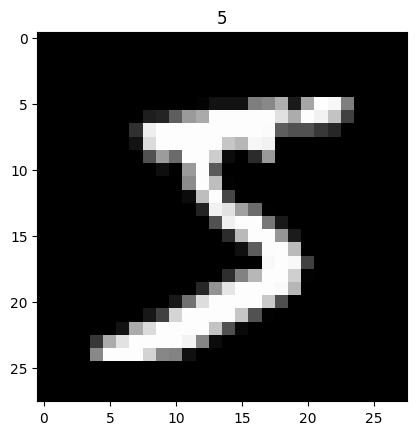

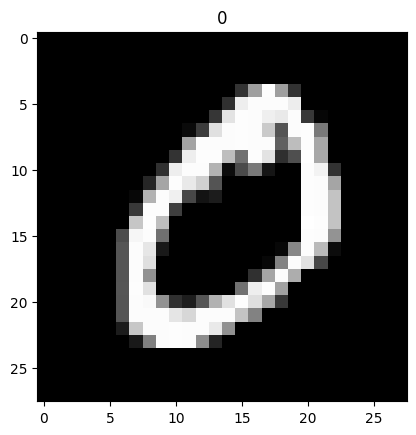

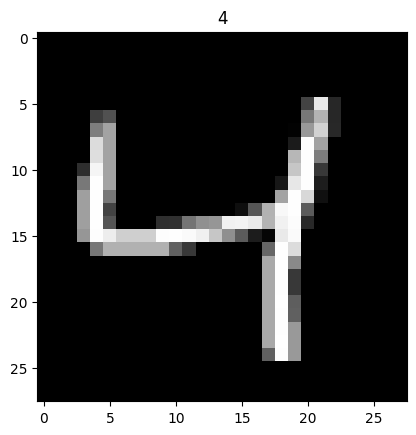

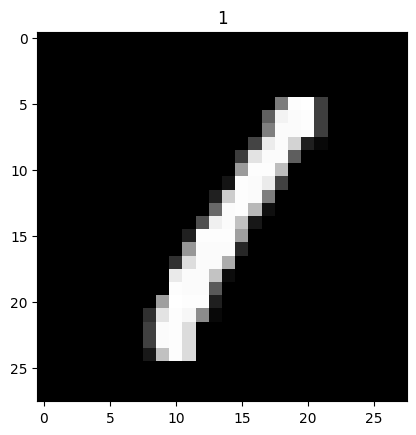

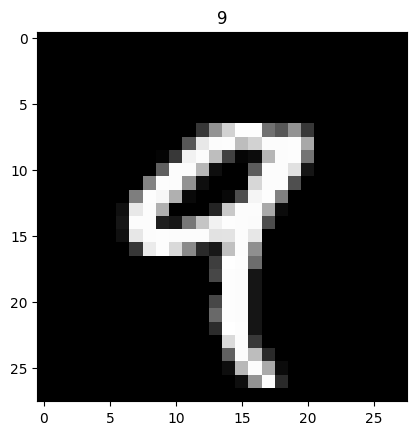

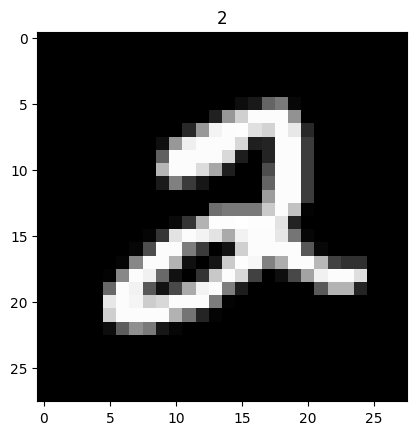

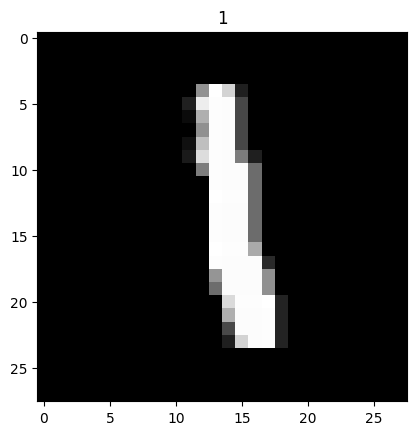

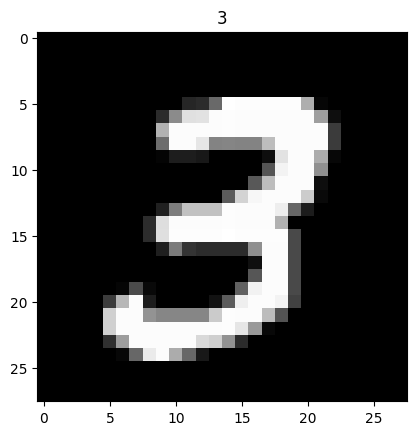

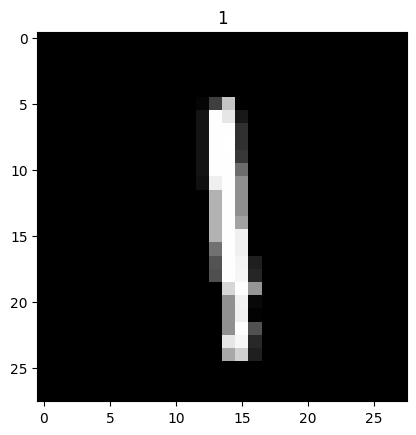

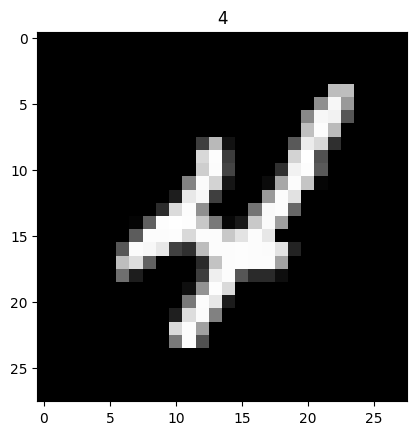

In [3]:
import numpy as np
from matplotlib import pyplot as plt

for i in range(10):
  plt.imshow(np.reshape(x[i, :],(28,28)), cmap='gray')
  plt.title(labels[i])
  plt.show()

## GRU vrstva

V pytorchi GRU vrstva očakáva na vstupe tenzor 3. rádu, kde jednolivé dimenzie sú: dĺžka sekvencie, batch, features. Teda v prípade ak chceme mať na vstupe len jeden element bude mať tvar $1 \times 1 \times f$, ak by sme mali sekvenciu dĺžky $n_t$ tak to bude $n_t \times 1 \times f$. Samozrjeme ak to budeme mať celý batch s $n_b$ prvkami bude vstup tvaru $n_t \times n_b \times n_b$.

GRU okrem toho na vstupe vyžaduje ešte skryté stavy ako tenzor druhého rádu s tvarom $d \times n_b \times h$, kde $h$ je veľkosť skrytého stavu a $d$ je počet GRU vrstiev.

Je možné pridať GRU aj keyword arguement `batch_first=True` ten prehodí prvé dve dimenzie, takže vstup bude tvaru $n_b \times n_t \times n_b$, hidden ostane v tvare $d \times n_b \times h$.

V ďalšej práci s GRU budem používať `batch_first=True` keďže je to pohodlnejšie.

In [4]:
import torch
from torch.nn import GRU

gru = GRU(32, 64)


# Môžeme do gru hodiť po jednom príklade
x = torch.rand(1, 1, 32)
h = torch.rand(1, 1, 64)

out, h = gru(x, h)

print(out.size())
print(h.size())


# Môžeme tiež použiť batch size 16
x = torch.rand(1, 16, 32)
h = torch.rand(1, 16, 64)

out, h = gru(x, h)

print(out.size())
print(h.size())


# Na vstupe môžeme mať aj dlhšiu sekvenciu
x = torch.rand(4, 16, 32)
# Skrytý stav však stále bude mať na vstupe 1
h = torch.rand(1, 16, 64)

out, h = gru(x, h)

print(out.size())
print(h.size())


# Môžeme mať aj viac GRU vrstvie za sebou

gru2 = GRU(32, 64, num_layers=2)
x = torch.rand(4, 16, 32)
h = torch.rand(2, 16, 64)

out, h = gru2(x, h)

print(out.size())
print(h.size())


# Ak použijeme batch_first=True tak potrebujeme iné tvary

gru_bf = GRU(32, 64, num_layers=2, batch_first=True)
x = torch.rand(16, 4, 32)
h = torch.rand(2, 16, 64)

out, h = gru_bf(x, h)

print(out.size())
print(h.size())

torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 16, 64])
torch.Size([1, 16, 64])
torch.Size([4, 16, 64])
torch.Size([1, 16, 64])
torch.Size([4, 16, 64])
torch.Size([2, 16, 64])
torch.Size([16, 4, 64])
torch.Size([2, 16, 64])


## Aplikácia iných vrstiev v sekvencii

Problém samozrejme bude ak by sme pred GRU vrstvou chceli najprv aplikovať konvolučné vrstvy.

![GRU](https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/ntb_images/GRU_model.png)

To je problém lebo prvá Conv2d očakáva na vstupe tvar $n_b \times 3 \times h \times w$, ale mi budeme mať sekvenciu $n_t \times n_b \times 3 \times h \times w$. Preto ak chceme aplikovať model, tak musíme najprv vstup upraviť do tvaru $n_tn_b \times 1 \times h \times w$. Na výstupe potom budeme mať po globálnom pooling $n_tn_b \times f_out$. A to budeme musieť opäť prekonvertovať na $n_tn_b \times f$.

Pre tento účel si napíšeme vlastný modul, ktorý bude obsahovať všetky vrstvy. Ako jediný parameter konštruktora bude počet výstupných tried. To bude nejaké prvočíslo ideálne väčšie ako 10. Cieľom našej siete bude prečítať posutpne číslo zľava doprava ako by bolo zapísané a potom spočítať jeho modulo našim prvočíslom.

Samozrejme si môžete sieť upraviť aby mala aj iný počet kanálov na vnútorných vrstvách.

In [5]:
from torch.nn import Module, Conv2d, Linear, GRU, BatchNorm2d, BatchNorm1d

class ConvGRUNet(Module):
  def __init__(self, n_out):
    super(ConvGRUNet, self).__init__()

    self.conv1 = Conv2d(1, 32, 5)
    self.conv2 = Conv2d(32, 32, 5)
    self.conv3 = Conv2d(32, 32, 5)
    self.conv4 = Conv2d(32, 64, 5)

    self.bn1 = BatchNorm2d(32)
    self.bn2 = BatchNorm2d(32)
    self.bn3 = BatchNorm2d(32)
    self.bn4 = BatchNorm2d(64)

    self.bn5 = BatchNorm1d(64)

    self.gru = GRU(64, 64, batch_first=True)
    self.linear = Linear(64, n_out)
    self.n_out = n_out


  def forward(self, x, h):
    s = x.size()
    x = x.reshape(s[0] * s[1], 1, 28, 28)

    x = self.conv1(x)
    x = torch.nn.functional.elu(x)
    x = self.bn1(x)
    x = self.conv2(x)
    x = torch.nn.functional.elu(x)
    x = self.bn2(x)
    x = self.conv3(x)
    x = torch.nn.functional.elu(x)
    x = self.bn3(x)
    x = self.conv4(x)
    x = torch.nn.functional.elu(x)
    x = self.bn4(x)

    x = torch.mean(x, dim=-1)
    x = torch.mean(x, dim=-1)

    x = x.reshape(s[0], s[1], 64)
    x, h = self.gru(x, h)
    x = x.reshape(s[0] * s[1], 64)
    x = self.bn5(x)
    x = self.linear(x)
    x = x.reshape(s[0], s[1], self.n_out)

    return x, h

net = ConvGRUNet(13)
x = torch.rand(16,10,28,28)
h = torch.rand(1, 16, 64)

out, out_h = net(x, h)
print(out.size())
print(out_h.size())

torch.Size([16, 10, 13])
torch.Size([1, 16, 64])


Môžeme si vybrať ako budeme trénovať túto sieť. Na vstupe budeme mať sekvenciu obrázkov tvaru $n_b \times n_t \times 1 \times 28 \times 28$. Tým že robím ereshape by sme ale mohli mať kľudne aj  $n_b \times n_t \times 28 \times 28$, alebo $n_b \times n_t \times 784$.

Na výstupe máme dve možnosti. Buď budeme sledovať len výstup na konci sekvencie a z neho rátať loss, alebo budeme trénovať sieť na všetky vstupy. Najprv otestujeme druhý prístup:

![GRU Multiloss](https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/ntb_images/GRU_multi_loss.png)

Na to si najprv ale budeme musieť napísať dataset aby nám dával sekvencie. Tu si teda v `__getitem__` budeme generovať vždy po páre vstupu a výstupu v tvare $n_t \times 28 \times 28$ a $n_t$. Ako vstup budeme pridávať postupne náhodné obrázky čísiel z MNISTu a ako výsup bude vždy modulo nejakým zvoleným číslom ak by sme zobrali vybratú sekvenciu a prečítali ju zľava do prava ako jedno číslo.

Náš dataset má v konštruktore následovné argumenty:

`x` - Numpy array veľkosti $n \times 784$ s MNIST obrázkami

`labels` - Numpy array s labelmi obrázkov

`modulo` - čislo ktorým budeme robiť modulo

`seq_length` - dĺžka štandardnej sekvencie

`length` - počet prvkov v jednej epoche, keďže čísla vyberáme náhodne

Metóda `__getitem__` generuje prvky v tvare $n_t \times 28 \times 28$ a $n_t$. Ak by sme nepoužili `batch_first=True` v GRU, tak pri štandardnom použití data loaderu by sa tieto prvky spojili do batch cez prvú dimenziu. To by bol problém, lebo potom by bolo napr. x tvaru $n_b \times n_t \times 28 \times 28$ a nie $n_t \times n_b \times 28 \times 28$. V takom prípade by bolo nutné v DataLoaderi pridať ešte funkciu collate ktorá dáta spojí tak ako chceme.

In [6]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class SeqDataset(Dataset):
  def __init__(self, x, labels, modulo, seq_length, length=10000):
    super(SeqDataset).__init__()
    self.x = x
    self.num_items = len(x)
    self.labels = labels
    self.modulo = modulo
    self.seq_length = seq_length
    self.length = length

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    xs = np.empty([self.seq_length, 28, 28], dtype=np.float32)
    ys = np.empty(self.seq_length, dtype=np.int64)

    val = 0
    for i in range(self.seq_length):
      idx = np.random.randint(self.num_items)
      val = 10 * val + self.labels[idx]
      xs[i] = np.reshape(self.x[idx], [28, 28])
      ys[i] = val % self.modulo

    return torch.from_numpy(xs), torch.from_numpy(ys)

dataset = SeqDataset(x_train, labels_train, 13, 10, length=32)
loader = DataLoader(dataset, batch_size=16)

# Ak by sme v GRU vrstve nepoužili batch_first=True, tak by sme museli spraviť niečo takéto.
# def collate_fn(items):
#   xs = [x[0] for x in items]
#   ys = [x[1] for x in items]

#   xs = torch.stack(xs, dim=1)
#   ys = torch.stack(ys, dim=1)
#   return xs, ys
#
# loader = DataLoader(dataset, batch_size=16, collate_fn=collate_fn)

for item in loader:
  x, y = item
  print(x.size())
  print(y.size())

torch.Size([16, 10, 28, 28])
torch.Size([16, 10])
torch.Size([16, 10, 28, 28])
torch.Size([16, 10])


Dataset si zobrazíme.

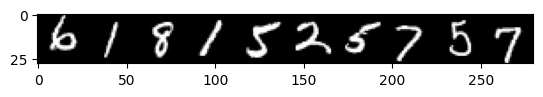

tensor([ 6,  9,  7,  6,  0,  2, 12, 10,  1,  4])


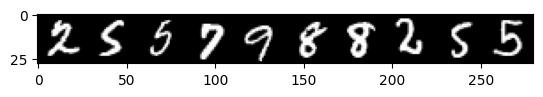

tensor([ 2, 12,  8,  9,  8, 10,  4,  3,  9,  4])


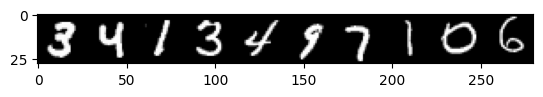

tensor([3, 8, 3, 7, 9, 8, 9, 0, 0, 6])


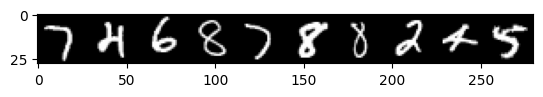

tensor([7, 9, 5, 6, 2, 2, 2, 9, 3, 9])


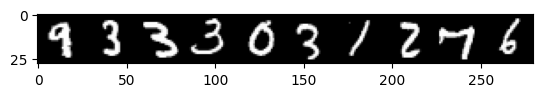

tensor([ 9,  2, 10, 12,  3,  7,  6, 10,  3, 10])


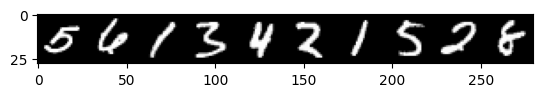

tensor([ 5,  4,  2, 10,  0,  2,  8,  7,  7,  0])


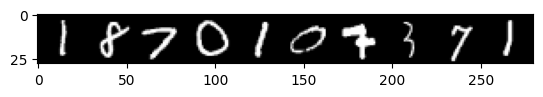

tensor([ 1,  5,  5, 11,  7,  5,  5,  1,  4,  2])


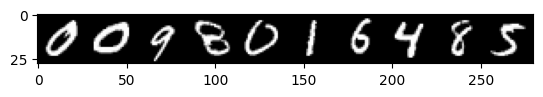

tensor([ 0,  0,  9,  7,  5, 12,  9,  3, 12,  8])


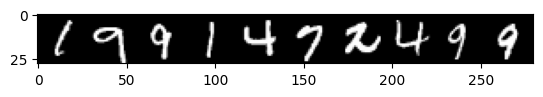

tensor([ 1,  6,  4,  2, 11,  0,  2, 11,  2,  3])


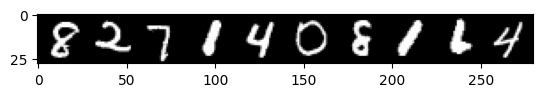

tensor([8, 4, 8, 3, 8, 2, 2, 8, 8, 6])


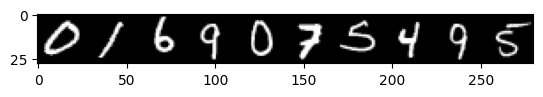

tensor([ 0,  1,  3,  0,  0,  7, 10,  0,  9,  4])


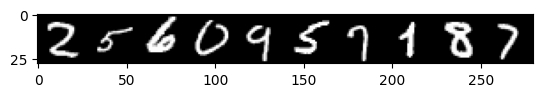

tensor([ 2, 12,  9, 12, 12,  8,  9,  0,  8,  9])


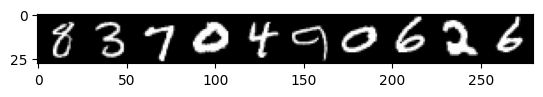

tensor([ 8,  5,  5, 11, 10,  5, 11, 12,  5,  4])


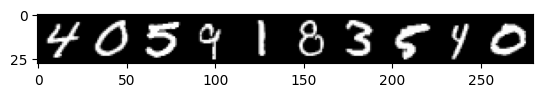

tensor([ 4,  1,  2,  3,  5,  6, 11, 11, 10,  9])


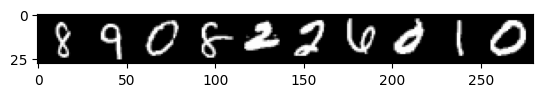

tensor([ 8, 11,  6,  3,  6, 10,  2,  0,  1, 10])


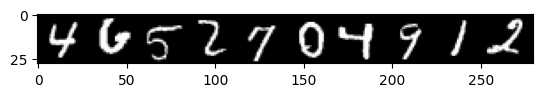

tensor([ 4,  7, 10, 11,  0,  0,  4, 10, 10, 11])


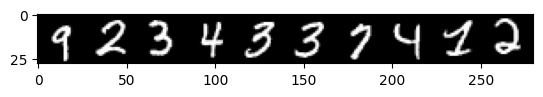

tensor([9, 1, 0, 4, 4, 4, 8, 6, 9, 1])


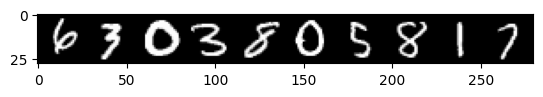

tensor([ 6, 11,  6, 11,  1, 10,  1,  5, 12, 10])


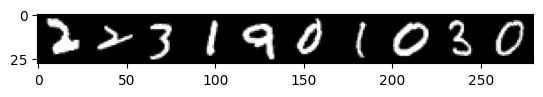

tensor([ 2,  9,  2,  8, 11,  6,  9, 12,  6,  8])


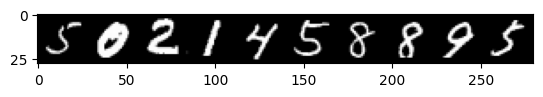

tensor([ 5, 11,  8,  3,  8,  7,  0,  8, 11, 11])


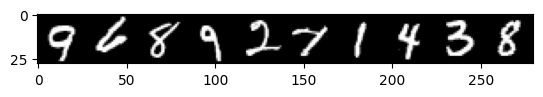

tensor([ 9,  5,  6,  4,  3, 11,  7,  9,  2,  2])


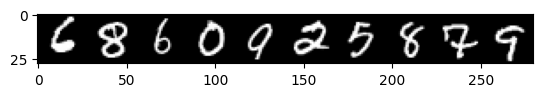

tensor([ 6,  3, 10,  9,  8,  4,  6,  3, 11,  2])


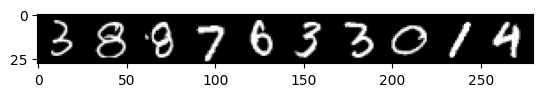

tensor([ 3, 12, 11,  0,  6, 11,  9, 12,  4,  5])


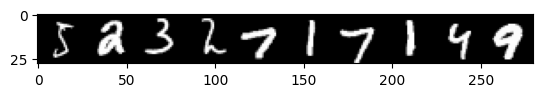

tensor([ 5,  0,  3,  6,  2,  8,  9,  0,  4, 10])


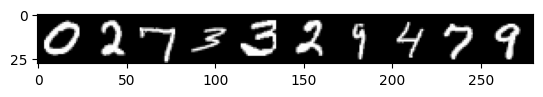

tensor([0, 2, 1, 0, 3, 6, 4, 5, 5, 7])


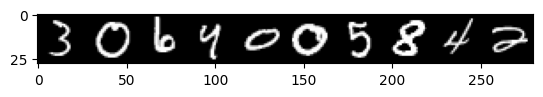

tensor([ 3,  4,  7,  9, 12,  3,  9,  7,  9,  1])


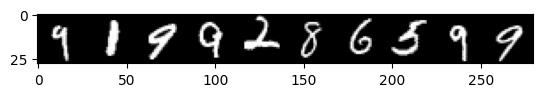

tensor([9, 0, 9, 8, 4, 9, 5, 3, 0, 9])


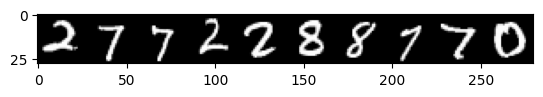

tensor([ 2,  1,  4,  3,  6,  3, 12, 10,  3,  4])


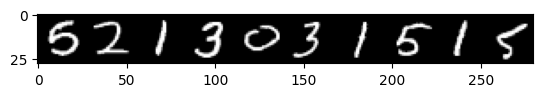

tensor([5, 0, 1, 0, 0, 3, 5, 3, 5, 3])


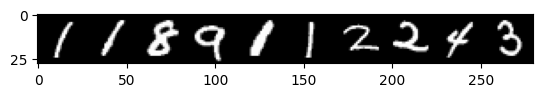

tensor([ 1, 11,  1,  6,  9,  0,  2,  9,  3,  7])


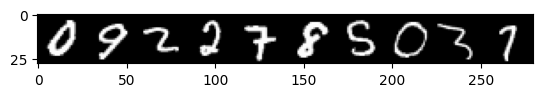

tensor([ 0,  9,  1, 12, 10,  4,  6,  8,  5,  5])


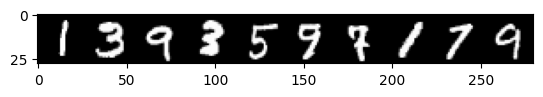

tensor([ 1,  0,  9,  2, 12, 12, 10, 10,  3,  0])


In [7]:
dataset = SeqDataset(x_train, labels_train, 13, 10, length=32)
loader = DataLoader(dataset, batch_size=1)

for item in loader:
  x, y = item
  x = x[0].numpy()
  img = np.concatenate(x, axis=1)
  plt.imshow(img, cmap='gray')
  plt.show()
  print(y[0])

## Tréning so stratou po každom výstupe

Teraz môžme pristúpiť k tréningu. Opäť si vytvoríme jednoduchý loop. Pri dataloaderi navyše použijeme keyword `drop_last=True` týmto sa neaplikuje posledný batch ktorý by nenaplnil celú batch size. Keďže generujeme poradie náhodne tak to ani nemá zmysel.

In [8]:
modulo = 13
seq_length = 6
batch_size = 16


dataset_train = SeqDataset(x_train, labels_train, modulo, seq_length)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, drop_last=True)

dataset_val = SeqDataset(x_val, labels_val, modulo, seq_length, length=1000)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, drop_last=True)

model = ConvGRUNet(modulo).cuda()
print(model)

ce_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for e in range(10):
  model.train()
  for i, samples in enumerate(dataloader_train):
    x = samples[0].cuda()
    y = samples[1].cuda()
    optimizer.zero_grad()

    h = torch.zeros(1, batch_size, 64, dtype=torch.float).cuda()
    out, h_out = model(x, h)

    out = out.reshape(-1, modulo)
    y = y.reshape(-1)
    loss = ce_loss(out, y)

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
      print("Loss at epoch: {} step {}: {}".format(e, i, loss.item()))

  model.eval()
  with torch.no_grad():
    val_losses = []
    correct = 0
    total = 0
    for i, samples in enumerate(dataloader_val):
      x = samples[0].cuda()
      y = samples[1].cuda()

      h = torch.zeros(1, batch_size, 64, dtype=torch.float).cuda()
      out, h_out = model(x, h)

      out = out.reshape(-1, modulo)
      y = y.reshape(-1)
      loss = ce_loss(out, y)

      acc = torch.sum(torch.argmax(out, dim=-1) == y)
      correct += acc.item()
      val_losses.append(loss.item())
      total += len(y)

    print("Val loss at epoch {}: {}".format(e, np.mean(val_losses)))
    print("Val acc at epoch {}: {}".format(e, correct / total))

ConvGRUNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru): GRU(64, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=13, bias=True)
)
Loss at epoch: 0 step 0: 2.6901893615722656
Loss at epoch: 0 step 100: 2.4965739250183105
Loss at epoch: 0 step 200: 2.5135321617126465
Loss at epoch: 0 step 300: 2.4536798000335693
Loss at epoch:

## Inferencia celej sekvencie

Model si otestujeme. Na vstup môžeme dávať celú sekvenciu.

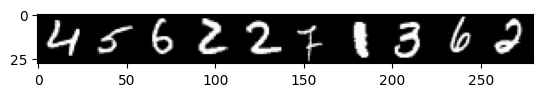

GT:  tensor([ 4,  6,  1, 12,  5,  5, 12,  6,  1, 12], device='cuda:0')
Output tensor([ 4,  6,  1, 12,  5,  3,  5,  8,  1,  6], device='cuda:0')


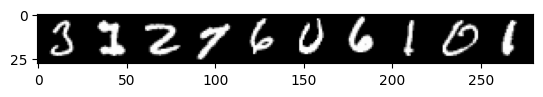

GT:  tensor([ 3,  5,  0,  7, 11,  6,  1, 11,  6,  9], device='cuda:0')
Output tensor([ 3,  6, 10,  3, 10,  9,  5, 12,  3,  5], device='cuda:0')


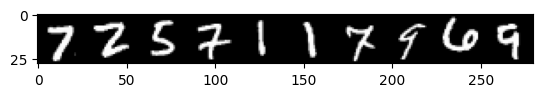

GT:  tensor([ 7,  7, 10,  3,  5, 12, 10,  5,  4, 10], device='cuda:0')
Output tensor([ 7,  7, 10,  3,  5, 12, 10,  5,  4, 10], device='cuda:0')


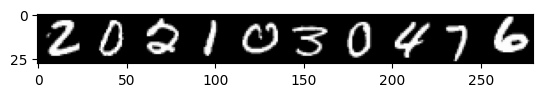

GT:  tensor([ 2,  7,  7,  6,  8,  5, 11, 10,  3, 10], device='cuda:0')
Output tensor([ 2,  7,  7,  6,  8,  5, 11, 10,  3, 10], device='cuda:0')


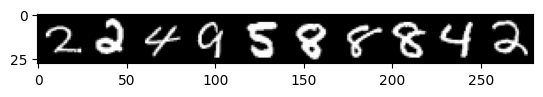

GT:  tensor([ 2,  9,  3,  0,  5,  6,  3, 12,  7,  7], device='cuda:0')
Output tensor([ 2,  9,  3,  0,  5,  6,  3, 12,  7,  7], device='cuda:0')


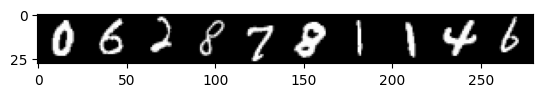

GT:  tensor([ 0,  6, 10,  4,  8, 10, 10, 10,  0,  6], device='cuda:0')
Output tensor([ 0,  6, 10,  4,  8, 10, 10, 10,  0,  6], device='cuda:0')


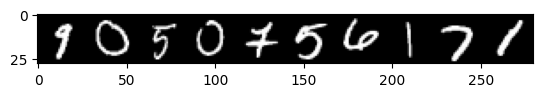

GT:  tensor([ 9, 12,  8,  2,  1,  2,  0,  1,  4,  2], device='cuda:0')
Output tensor([ 9, 12,  8,  2,  1,  2,  0,  1,  4,  2], device='cuda:0')


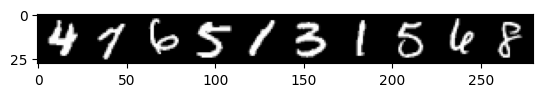

GT:  tensor([ 4,  8,  8,  7,  6, 11,  7, 10,  2,  2], device='cuda:0')
Output tensor([ 4,  8,  8,  7,  6, 11,  7, 10,  2,  2], device='cuda:0')


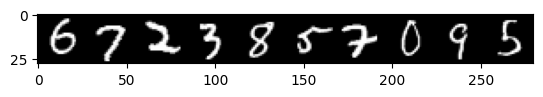

GT:  tensor([ 6,  2,  9,  2,  2, 12, 10,  9,  8,  7], device='cuda:0')
Output tensor([ 6,  2,  9,  2,  2, 12, 10,  9,  8,  7], device='cuda:0')


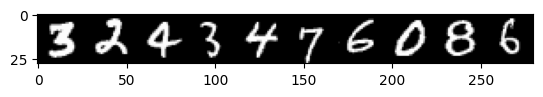

GT:  tensor([ 3,  6, 12,  6, 12, 10,  2,  7,  0,  6], device='cuda:0')
Output tensor([ 3,  6, 12,  6, 12, 10,  2,  7,  0,  6], device='cuda:0')


In [9]:
modulo = 13
seq_length = 10

dataset = SeqDataset(x_test, labels_test, modulo, seq_length, length=10)
loader = DataLoader(dataset, batch_size=1)

model.eval()

for samples in loader:
  x = samples[0].cuda()
  y = samples[1].cuda()

  h = torch.zeros(1, 1, 64).cuda()
  out, h_out = model(x, h)
  img = np.concatenate(x[0].cpu().numpy(), axis=1)
  plt.imshow(img, cmap='gray')
  plt.show()
  print("GT: ", y[0])
  print("Output", torch.argmax(out[0], dim=-1))

## Inferencia po častiach

Inferenciu môžeme robiť aj po častiach. V nasledujúcom kóde napríklad budeme brať postupne vstupy rad za radom.

Starting new sequence!


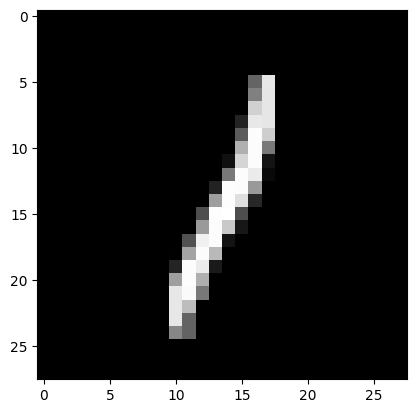

Val:  1 Modulo:  1 Out:  tensor([1], device='cuda:0')


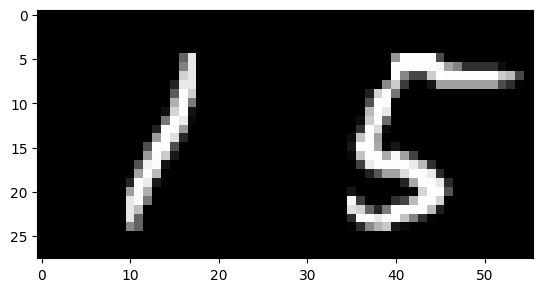

Val:  15 Modulo:  2 Out:  tensor([2], device='cuda:0')


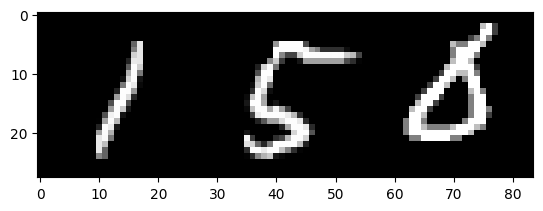

Val:  150 Modulo:  7 Out:  tensor([7], device='cuda:0')


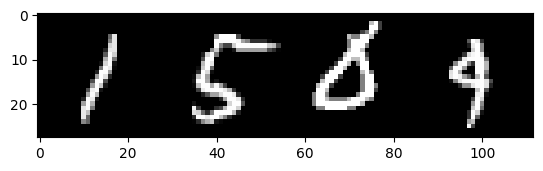

Val:  1504 Modulo:  9 Out:  tensor([9], device='cuda:0')


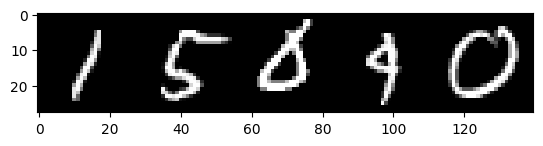

Val:  15040 Modulo:  12 Out:  tensor([12], device='cuda:0')


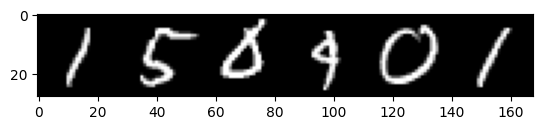

Val:  150401 Modulo:  4 Out:  tensor([4], device='cuda:0')


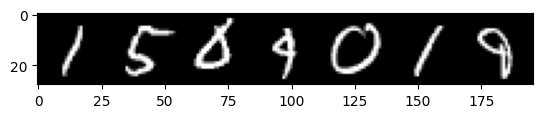

Val:  1504019 Modulo:  10 Out:  tensor([10], device='cuda:0')


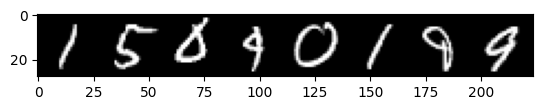

Val:  15040199 Modulo:  5 Out:  tensor([5], device='cuda:0')


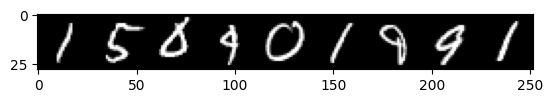

Val:  150401991 Modulo:  12 Out:  tensor([12], device='cuda:0')


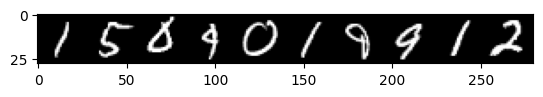

Val:  1504019912 Modulo:  5 Out:  tensor([5], device='cuda:0')
Starting new sequence!


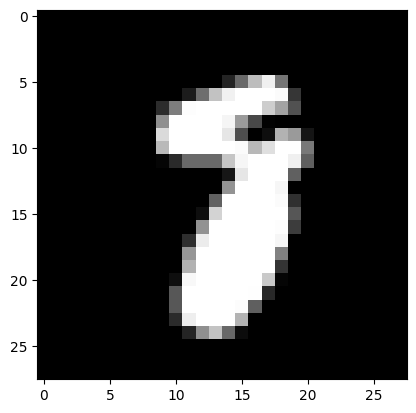

Val:  8 Modulo:  8 Out:  tensor([8], device='cuda:0')


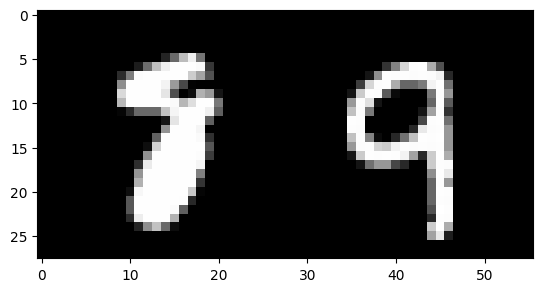

Val:  89 Modulo:  11 Out:  tensor([11], device='cuda:0')


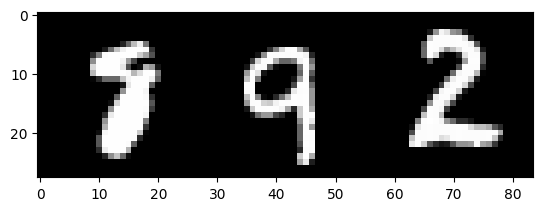

Val:  892 Modulo:  8 Out:  tensor([8], device='cuda:0')


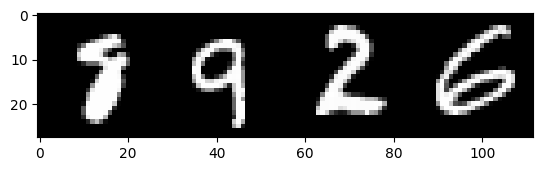

Val:  8926 Modulo:  8 Out:  tensor([8], device='cuda:0')


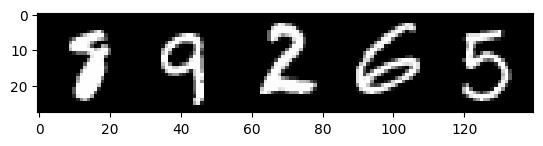

Val:  89265 Modulo:  7 Out:  tensor([7], device='cuda:0')


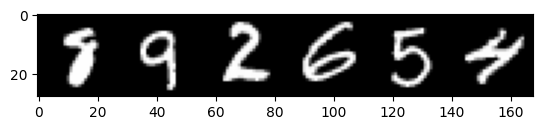

Val:  892654 Modulo:  9 Out:  tensor([2], device='cuda:0')


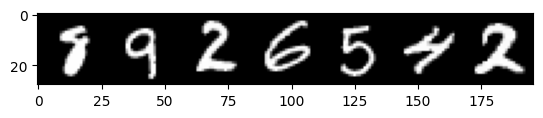

Val:  8926542 Modulo:  1 Out:  tensor([1], device='cuda:0')


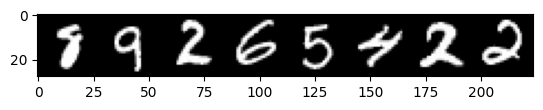

Val:  89265422 Modulo:  12 Out:  tensor([12], device='cuda:0')


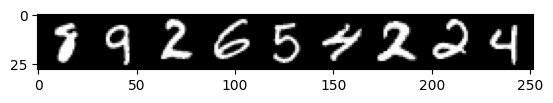

Val:  892654224 Modulo:  7 Out:  tensor([0], device='cuda:0')


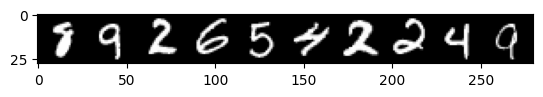

Val:  8926542249 Modulo:  1 Out:  tensor([6], device='cuda:0')


In [10]:
for seq in range(2):
  print("Starting new sequence!")
  imgs = []
  h = torch.zeros(1, 1, 64).cuda()
  val = 0
  for i in range(10):

    idx = np.random.randint(len(x_test))
    val = val * 10 + labels_test[idx]
    img = np.reshape(x_test[idx], [28, 28])
    imgs.append(img)
    plt.imshow(np.concatenate(imgs, axis=1), cmap='gray')
    plt.show()

    x = torch.from_numpy(img[np.newaxis, np.newaxis, ...]).float().cuda()

    out, h = model(x, h)
    print("Val: ", val, "Modulo: ", val % modulo, "Out: ", torch.argmax(out[0], dim=-1))




## Stratová funkcia len na konci

Teraz vyskúšame trénovanie tak, že chybu budeme počítať len z konca celej sekvencie.

![alt text](https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/ntb_images/GRU_single_loss.png)

Doimplemntujte trénovací cyklus. Môžete kľudne skopírovať predchádzajúci kód a upraviť ho.

Tento prístup vám s najväčšou pravdepodobnosťou nebude fungovať a s najväčšou pravdebodobnosťou sa vôbec nenatrénuje.

In [11]:
modulo = 13
seq_length = 6
batch_size = 16


dataset_train = SeqDataset(x_train, labels_train, modulo, seq_length)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, drop_last=True)

dataset_val = SeqDataset(x_val, labels_val, modulo, seq_length, length=1000)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, drop_last=True)

model = ConvGRUNet(modulo).cuda()
print(model)

ce_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for e in range(10):
  model.train()
  for i, samples in enumerate(dataloader_train):
    x = samples[0].cuda()
    y = samples[1].cuda()
    optimizer.zero_grad()

    h = torch.zeros(1, batch_size, 64, dtype=torch.float).cuda()
    out, h_out = model(x, h)

    loss = ce_loss(out[:, -1, :], y[:, -1])

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
      print("Loss at epoch: {} step {}: {}".format(e, i, loss.item()))

  model.eval()
  with torch.no_grad():
    val_losses = []
    correct = 0
    total = 0
    for i, samples in enumerate(dataloader_val):
      x = samples[0].cuda()
      y = samples[1].cuda()

      h = torch.zeros(1, batch_size, 64, dtype=torch.float).cuda()
      out, h_out = model(x, h)

      out = out.reshape(-1, modulo)
      y = y.reshape(-1)
      loss = ce_loss(out, y)

      acc = torch.sum(torch.argmax(out, dim=-1) == y)
      correct += acc.item()
      val_losses.append(loss.item())
      total += len(y)

    print("Val loss at epoch {}: {}".format(e, np.mean(val_losses)))
    print("Val acc at epoch {}: {}".format(e, correct / total))

ConvGRUNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru): GRU(64, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=13, bias=True)
)
Loss at epoch: 0 step 0: 2.9678878784179688
Loss at epoch: 0 step 100: 2.5869462490081787
Loss at epoch: 0 step 200: 2.622894048690796
Loss at epoch: 0 step 300: 2.5889337062835693
Loss at epoch: 

## Variabilná dĺžka vstupu

Teraz si skúsime rovnaký prístup ale vždy na vstupe budeme mať pre každý batch inú dĺžku. Momentálne si to implementujte tak, že použijeme existujúci generátor s nejakom maximálnou dĺžkou a zo sekvencie si potom zoberieme len náhodný počet prvých prvkov.

Samozrejme dalo by sa to spraviť aj elegantnejšie, ale to je komplikovanejšie. Taktiež by bolo možné napríklad upraviť batch size tak aby sme pri kratších sekvenciách mali väčšie batche a naopak aby sme naplno využili pamäť.

Napíšte dole kód a vyskúšajte si trénovanie s loss pre všetky prvky ak bude v každom trénovacom kroku variabilný dĺžka trénovania.

In [12]:
modulo = 13
max_seq_length = 15
val_seq_length = 8
batch_size = 16


dataset_train = SeqDataset(x_train, labels_train, modulo, max_seq_length)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, drop_last=True)

dataset_val = SeqDataset(x_val, labels_val, modulo, val_seq_length, length=1000)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, drop_last=True)

model = ConvGRUNet(modulo).cuda()
print(model)

ce_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for e in range(10):
  model.train()
  for i, samples in enumerate(dataloader_train):
    x = samples[0].cuda()
    y = samples[1].cuda()
    optimizer.zero_grad()

    h = torch.zeros(1, batch_size, 64, dtype=torch.float).cuda()

    length = np.random.randint(max_seq_length)

    out, h_out = model(x[:, :length + 1, ...], h)

    # Loss priebežne
    out = out.reshape(-1, modulo)
    y = y[:, :length + 1].reshape(-1)
    loss = ce_loss(out, y)

    # Loss na konci nefunguje
    # loss = ce_loss(out[:, -1, :], y[:, length])

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
      print("Loss at epoch: {} step {}: {}".format(e, i, loss.item()))

  model.eval()
  with torch.no_grad():
    val_losses = []
    correct = 0
    total = 0
    for i, samples in enumerate(dataloader_val):
      x = samples[0].cuda()
      y = samples[1].cuda()

      h = torch.zeros(1, batch_size, 64, dtype=torch.float).cuda()
      out, h_out = model(x, h)

      out = out.reshape(-1, modulo)
      y = y.reshape(-1)
      loss = ce_loss(out, y)

      acc = torch.sum(torch.argmax(out, dim=-1) == y)
      correct += acc.item()
      val_losses.append(loss.item())
      total += len(y)

    print("Val loss at epoch {}: {}".format(e, np.mean(val_losses)))
    print("Val acc at epoch {}: {}".format(e, correct / total))

ConvGRUNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru): GRU(64, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=13, bias=True)
)
Loss at epoch: 0 step 0: 2.695422887802124
Loss at epoch: 0 step 100: 2.415393352508545
Loss at epoch: 0 step 200: 2.5490591526031494
Loss at epoch: 0 step 300: 2.500685453414917
Loss at epoch: 0 